In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cv2
import pywt
from scipy.signal import wiener
import skimage as skimg 

from sklearn.preprocessing import (MinMaxScaler, StandardScaler, Normalizer, FunctionTransformer)
from sklearn.model_selection import (train_test_split, StratifiedKFold, ShuffleSplit)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import (SVC)

from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.pipeline import (Pipeline, make_pipeline, FeatureUnion, make_union)
from sklearn.metrics import (classification_report, accuracy_score)

import os
from tqdm import tqdm

### Constant

In [2]:
PATH_PREFIX = '/home/thienn17/Documents/ICL/'
os.path.exists(PATH_PREFIX)

True

In [3]:
class CLASS():
    FAKE = 0
    REAL = 1

WT_NAME = 'db5'
LEVEL = 3

### Load image

In [79]:
def load_img():
    cls_folders = os.listdir(PATH_PREFIX)
    images = []
    labels = []

    for cls_folder in cls_folders:
        if cls_folder == 'dummy':
            continue
        for abspath, _, files in os.walk(os.path.join(PATH_PREFIX, cls_folder)):
            for file in tqdm(files):
                # file = os.path.join(abspath, file)
                img = cv2.imread(os.path.join(abspath, file), cv2.IMREAD_GRAYSCALE)
                # img = cv2.imread(os.path.join(abspath, file))
                if img is not None:
                    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(img)
                    labels.append(CLASS.REAL if file[0] == 's' else CLASS.FAKE)
                    
    
    return (images, labels)

0it [00:00, ?it/s]
100%|██████████| 100/100 [00:06<00:00, 16.53it/s]
0it [00:00, ?it/s]
100%|██████████| 180/180 [00:13<00:00, 12.86it/s]


### Feature Transformer

In [5]:
class WaveletFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, wtname = 'db5', level = 3):
        '''
        waveletname = ['db3', 'db4', 'db5', 'sym2', 'bior5.5', etc.]
        level: total number of decomposite level
        '''
        self.wtname = wtname
        self.level = level

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return self.get_wavelet_features(X)

    def get_wavelet_features(self, images):
        def wavelet_decrete_transform(img):
            wt = pywt.wavedec2(data=img, wavelet=self.wtname, level=self.level)
            apprx = wt[0]
            details = wt[1:]
            return apprx, details

        def get_wavelet_characteristics(apprx, details):
            def get_mean(img_wt: np.ndarray):
                return np.mean(img_wt)

            def get_variance(img_wt: np.ndarray):
                img_wt = img_wt - mean
                img_wt = img_wt**2
                return np.mean(img_wt)

            def get_skew(img_wt: np.ndarray):
                img_wt = img_wt - mean
                img_wt = img_wt**3
                return np.mean(img_wt)

            def get_single_chrc(img_wt):
                mean = get_mean(img_wt)
                return (mean, get_variance(img_wt), get_skew(img_wt))

            mean = 0
            chrc = []
            for a in get_single_chrc(apprx):
                chrc.append(a)
            for level_detail in details:
                for h in level_detail:
                    for a in get_single_chrc(h):
                        chrc.append(a)
            return np.array(chrc)

        wt_features = []
        for img in tqdm(images):
            img_low_pass, img_high_pass = wavelet_decrete_transform(img)
            wt_features.append(get_wavelet_characteristics(img_low_pass, img_high_pass))
        
        # wt_features = MinMaxScaler().fit_transform(wt_features)
        return np.array(wt_features)

In [6]:
class MoreWavetletFeatureTfm(BaseEstimator, TransformerMixin):
    def __init__(self, wtname = 'db5', level = 3):
        '''
        waveletname = ['db3', 'db4', 'db5', 'sym2', 'bior5.5', etc.]
        level: total number of decomposite level
        '''
        self.wtname = wtname
        self.level = level

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        wt_features = []
        for img in tqdm(X):
            img_low_pass, img_high_pass = self.wavelet_decrete_transform(img)
            wt_features.append(self.get_feature(img_low_pass, img_high_pass))
        return np.array(wt_features)
    
    def wavelet_decrete_transform(self, img):
        wt = pywt.wavedec2(data=img, wavelet=self.wtname, level=self.level)
        apprx = wt[0]
        details = wt[1:]
        return apprx, details

    def get_feature(self, apprx, details):
        f = []
        for a in self.get_single_img_features(apprx):
            f.append(a)
        for level_detail in details:
            for h in level_detail:
                for a in self.get_single_img_features(h):
                    f.append(a)
        return f

    def get_single_img_features(self, img):
        # img = img.flatten()
        # entropy = self.calculate_entropy(img)
        # crossings = self.calculate_crossings(img)
        statistics = self.calculate_statistics(img)
        # return np.concatenate((entropy, crossings, statistics))
        return statistics

    def calculate_statistics(self, img):
        n5 = np.percentile(img, 5)
        n25 = np.percentile(img, 25)
        n75 = np.percentile(img, 75)
        n95 = np.percentile(img, 95)
        median = np.percentile(img, 50)
        mean = np.mean(img)
        std = np.std(img)
        var = np.var(img)
        skew = np.mean((img - mean)**3)
        rms = np.mean(np.sqrt(img**2))
        return (n5, n25, n75, n95, median, mean, std, var, skew, rms)

    # def calculate_entropy(self, list_values):
    #     counter_values = collections.Counter(list_values).most_common()
    #     probabilities = [elem[1]/len(list_values) for elem in counter_values]
    #     entropy=scipy.stats.entropy(probabilities)
    #     return entropy

    # def calculate_crossings(self, img):
    #     zero_crossing_indices = np.nonzero(np.diff(np.array(img), 0))[0]
    #     no_zero_crossings = len(zero_crossing_indices)
    #     mean_crossing_indices = np.nonzero(np.diff(np.array(img), np.nanmean(img)))[0]
    #     no_mean_crossings = len(mean_crossing_indices)
    #     return [no_zero_crossings, no_mean_crossings]

In [7]:
class NoiseFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_points = 8, radius = 1, wiener_size = 5):
        self.num_points = num_points
        self.radius = radius
        self.wiener_size = wiener_size
        # self.ravel = 0

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return self.get_lbp_features(X)

    def get_lbp_features(self, images):
        def local_binary_pattern(img):
            noise = img - wiener(img, self.wiener_size)
            lbp = skimg.feature.local_binary_pattern(
                noise, self.num_points, self.radius, method="nri_uniform").ravel()
            # (hist, bins) = np.histogram(lbp.ravel(), bins=59)
            bins, hist = np.unique(lbp.ravel(), return_counts=True)
            
            # hist = hist / len(lbp)
            return hist

        lbp_features = []
        for img in tqdm(images):
            # img = cv2.resize(img, LBP_IMG_SIZE)
            lbp_features.append(local_binary_pattern(img))
        return lbp_features

In [8]:
def percentage_normalize(X):
    X_normalized = []
    for x in X:
        x = x / np.sum(x)
        X_normalized.append(x)
    return np.array(X_normalized)

per_normalizer = FunctionTransformer(percentage_normalize)

In [9]:
def get_wt_feature(X):
    return X[:, :30]

def get_n_feature(X):
    return X[:, 30:]

# Train

In [10]:
import warnings
warnings.filterwarnings("ignore")

#### Load feature

In [11]:
PATH_DUMP = './object dump/no union/'
# PATH_DUMP = 'D:/About me/intern/2022-05-09-FPT High order wavelet/code/recaptured image - wavelet (sun2017)/object dump'
os.path.exists(PATH_DUMP)

True

In [68]:
Af = np.concatenate((
        np.load(os.path.join(PATH_DUMP, 'DS05_full_wt.npy')),
        np.load(os.path.join(PATH_DUMP, 'DS05_full_n.npy'))),
        axis=1)
b = np.load(os.path.join(PATH_DUMP, 'DS05_full_label.npy'))

In [69]:
print(Af.shape, b.shape)

(2345, 89) (2345,)


##### Load & concat Cable and DS05 small

In [97]:
b_ds = np.ones(Af.shape[0])*2
b_ds.shape

(2345,)

In [98]:
if os.path.exists(PATH_DUMP) is True:
    A_c = np.concatenate((np.load(os.path.join(PATH_DUMP, 'Cable_wt.npy')),
                          np.load(os.path.join(PATH_DUMP, 'Cable_n.npy'))),
                         axis=1)
    b_c = np.load(os.path.join(PATH_DUMP, 'Cable_label.npy'))

    A_d = np.concatenate((np.load(os.path.join(PATH_DUMP, 'DS05_small_wt.npy')),
                          np.load(os.path.join(PATH_DUMP, 'DS05_small_n.npy'))),
                         axis=1)
    b_d = np.load(os.path.join(PATH_DUMP, 'DS05_small_label.npy'))

    print(A_c.shape, b_c.shape)
    print(A_d.shape, b_d.shape)

    Af = np.concatenate((Af, A_c, A_d), axis=0)
    b = np.concatenate((b, b_c, b_d), axis=0)
    b_ds = np.concatenate((b_ds,
                           np.zeros(A_c.shape[0]),
                           np.ones(A_d.shape[0])),
                           axis=0)

(492, 89) (492,)
(150, 89) (150,)


In [99]:
print(Af.shape, b.shape, b_ds.shape)

(2987, 89) (2987,) (2987,)


### Fit

#### Pipeline

In [17]:
# wt_transform = make_pipeline(FunctionTransformer(get_wt_feature), StandardScaler())
# noise_transform = make_pipeline(FunctionTransformer(get_n_feature), FunctionTransformer(percentage_normalize))
# feature_transform = make_union(wt_transform, noise_transform)

wt_transform = Pipeline(steps=[
    ('slice_wt', FunctionTransformer(get_wt_feature)),
    ('mm_scaler', MinMaxScaler())
])
noise_transform = Pipeline(steps=[
    ('slice_noise', FunctionTransformer(get_n_feature)),
    ('std_scaler', FunctionTransformer(percentage_normalize))
])

In [90]:
feature_transform = [
    make_union(wt_transform, noise_transform),
    make_union(FunctionTransformer(get_wt_feature), FunctionTransformer(get_n_feature)),  # wrong <= dependent on image size
]

In [91]:
i = 0
estimators = [
    make_pipeline(feature_transform[i], StandardScaler(), SVC()),  # 97.7 (i=0)
    make_pipeline(feature_transform[i], MinMaxScaler(), SVC()),  # 97
    make_pipeline(feature_transform[i], StandardScaler(), GradientBoostingClassifier()),  # 98.2 (i=0)
    make_pipeline(feature_transform[i], MinMaxScaler(), GradientBoostingClassifier()),  # 98.2
]

#### Single fit

In [21]:
# Af_train, Af_test, b_train, b_test = train_test_split(Af, b,
#                                                       train_size=0.7,
#                                                       random_state=12,
#                                                       stratify=b)

In [107]:
rs = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, test_idx in rs.split(Af):
    Af_train = Af[train_idx]
    Af_test = Af[test_idx]
    b_train = b[train_idx]
    b_test = b[test_idx]
    b_ds_test = b_ds[test_idx]

In [108]:
Af_train.shape

(2090, 89)

In [109]:
estimator = estimators[0].fit(Af_train, b_train)
estimator

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('slice_wt',
                                                                  FunctionTransformer(func=<function get_wt_feature at 0x7f61cac1caf0>)),
                                                                 ('mm_scaler',
                                                                  MinMaxScaler())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('slice_noise',
                                                                  FunctionTransformer(func=<function get_n_feature at 0x7f61cac1cb80>)),
                                                                 ('std_scaler',
                                                                  FunctionTransformer(func=<function percentage_normalize at 0x7f61cac0bb80>))]))])),
                ('standardscaler', StandardScaler()), ('svc', SVC())])

In [110]:
b_pred = estimator.predict(Af_test)
print(classification_report(b_test, b_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       527
           1       0.99      0.94      0.96       370

    accuracy                           0.97       897
   macro avg       0.97      0.96      0.97       897
weighted avg       0.97      0.97      0.97       897



In [111]:
acc_list = (b_pred!=b_test)
print('Count incorrect pred with ground truth class (fake, real):')
print(np.count_nonzero((acc_list) & (b_test==0)),
      np.count_nonzero((acc_list) & (b_test==1)))

print('Count incorrect predict with dataset (Cable, DS05_small, DS05_full):')
print(np.count_nonzero((acc_list) & (b_ds_test==0)),
      np.count_nonzero((acc_list) & (b_ds_test==1)),
      np.count_nonzero((acc_list) & (b_ds_test==2)),)

Count incorrect pred with ground truth class (fake, real):
5 23
Count incorrect predict with dataset (Cable, DS05_small, DS05_full):
0 8 20


#### KFold

In [112]:
def kfold(_estimator):
    # print(_estimator)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = 0
    for k, (i_train, i_test) in enumerate(kf.split(Af, b)):
        model = _estimator.fit(Af[i_train], b[i_train])

        y_pred = model.predict(Af[i_test])
        acc = accuracy_score(y_true=b[i_test], y_pred=y_pred)
        score += acc

        print("[Fold {}] Acc: {:.3f}".format(k+1, acc))
        # print(classification_report(y_true=b[i_test], y_pred=y_pred))
        # print("Acc: {:.3f}".format(acc))

    print("Mean acc: {:.3f}\n".format(score/kf.get_n_splits()))

In [113]:
for e in estimators:
    kfold(e)

[Fold 1] Acc: 0.952
[Fold 2] Acc: 0.970
[Fold 3] Acc: 0.977
[Fold 4] Acc: 0.963
[Fold 5] Acc: 0.975
Mean acc: 0.967

[Fold 1] Acc: 0.933
[Fold 2] Acc: 0.938
[Fold 3] Acc: 0.936
[Fold 4] Acc: 0.938
[Fold 5] Acc: 0.946
Mean acc: 0.938

[Fold 1] Acc: 0.957
[Fold 2] Acc: 0.963
[Fold 3] Acc: 0.980
[Fold 4] Acc: 0.968
[Fold 5] Acc: 0.975
Mean acc: 0.969

[Fold 1] Acc: 0.957
[Fold 2] Acc: 0.965
[Fold 3] Acc: 0.980
[Fold 4] Acc: 0.968
[Fold 5] Acc: 0.975
Mean acc: 0.969



#### GroupFold

In [44]:
from sklearn.model_selection import (LeaveOneGroupOut, cross_val_score)

In [53]:
def groupfold(_estimator):
    # print(_estimator)
    
    logo = LeaveOneGroupOut()
    score = 0
    for k, (i_train, i_test) in enumerate(logo.split(Af, b, b_ds)):
        model = _estimator.fit(Af[i_train], b[i_train])

        y_pred = model.predict(Af[i_test])
        acc = accuracy_score(y_true=b[i_test], y_pred=y_pred)
        score += acc

        print("[Test dataset {} - len {}] Acc: {:.3f}".format(k, len(i_test), acc))
        # print(classification_report(y_true=b[i_test], y_pred=y_pred))
        # print("Acc: {:.3f}".format(acc))

    print("Mean acc: {:.3f}\n".format(score/5))

In [54]:
for e in estimators:
    groupfold(e)

[Test dataset 0 - len 492] Acc: 0.467
[Test dataset 1 - len 150] Acc: 0.620
[Test dataset 2 - len 2345] Acc: 0.356
Mean acc: 0.289

[Test dataset 0 - len 492] Acc: 0.278
[Test dataset 1 - len 150] Acc: 0.620
[Test dataset 2 - len 2345] Acc: 0.448
Mean acc: 0.269

[Test dataset 0 - len 492] Acc: 0.154
[Test dataset 1 - len 150] Acc: 0.527
[Test dataset 2 - len 2345] Acc: 0.110
Mean acc: 0.158

[Test dataset 0 - len 492] Acc: 0.165
[Test dataset 1 - len 150] Acc: 0.527
[Test dataset 2 - len 2345] Acc: 0.110
Mean acc: 0.160



In [ ]:
for e in estimators:
    logo = LeaveOneGroupOut()
    print(e)
    print(cross_val_score(e, Af, b, groups=b_ds, cv=logo.split(Af, b, b_ds)))

### Visualize

In [32]:
import umap
import seaborn as sns

In [33]:
sns_cmap = sns.color_palette()
color_mapper = {
    0 : sns_cmap[9],  # fake
    1 : sns_cmap[6],  # real
    2 : sns_cmap[2],  # f
    3 : sns_cmap[3],  # r
    4 : sns_cmap[0],  # f
    5 : sns_cmap[1],  # r
}
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [34]:
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    random_state=42)
scaler = make_pipeline(feature_transform, StandardScaler())

In [35]:
Af_s = scaler.fit_transform(Af)

In [36]:
embedding = reducer.fit_transform(Af_s)
embedding.shape

(2987, 2)

Text(0.5, 1.0, 'DS05-full - No resize - 50')

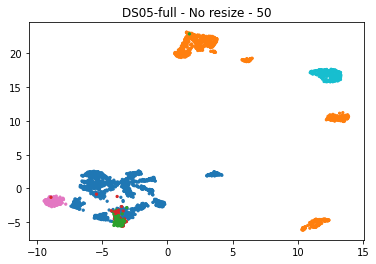

In [37]:
fig, ax = plt.subplots()
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a + 2*b_ds[i]] for i, a in enumerate(b)],
    s=5)
ax.set_title('DS05-full - {} - {}'.format('No resize', reducer.n_neighbors))

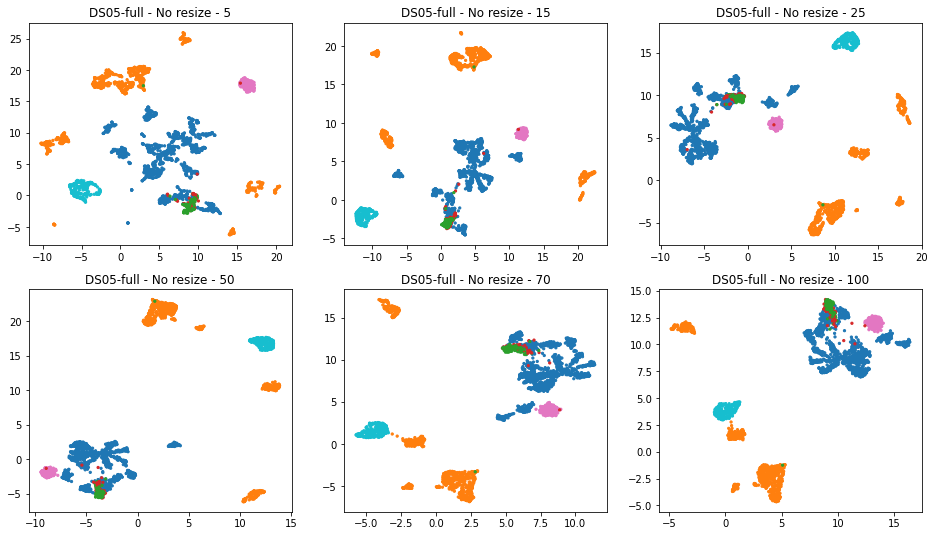

In [41]:
N = (5, 15, 25, 50, 70, 100)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
for a,n in enumerate(N):
    reducer = umap.UMAP(n_neighbors=n,
                        min_dist=0.25,
                        random_state=42)
    embedding = reducer.fit_transform(Af_s)
    i = a // 3
    j = a % 3
    axs[i,j].scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[color_mapper[a+ 2*b_ds[i]] for i, a in enumerate(b)],
        s=5)
    axs[i,j].set_title('DS05-full - {} - {}'.format('No resize', reducer.n_neighbors))
    # axs[i,j].set_xticks([])
    # axs[i,j].set_yticks([])
plt.show()